In [81]:
import os
import urllib.request
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from data_cleaning import data_cleaner_and_manipulator

## Acquire data functions

In [5]:
def fetch_housing_data(housing_url, housing_path):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path,'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [6]:
def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [7]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [8]:
fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH)

In [9]:
df = load_housing_data(housing_path = HOUSING_PATH)

## Data Analysis

In [10]:
# First of all we take a look at some instances of the data
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [11]:
# We look how many instances there are in each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
# Then we take a look at some statiscal values
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


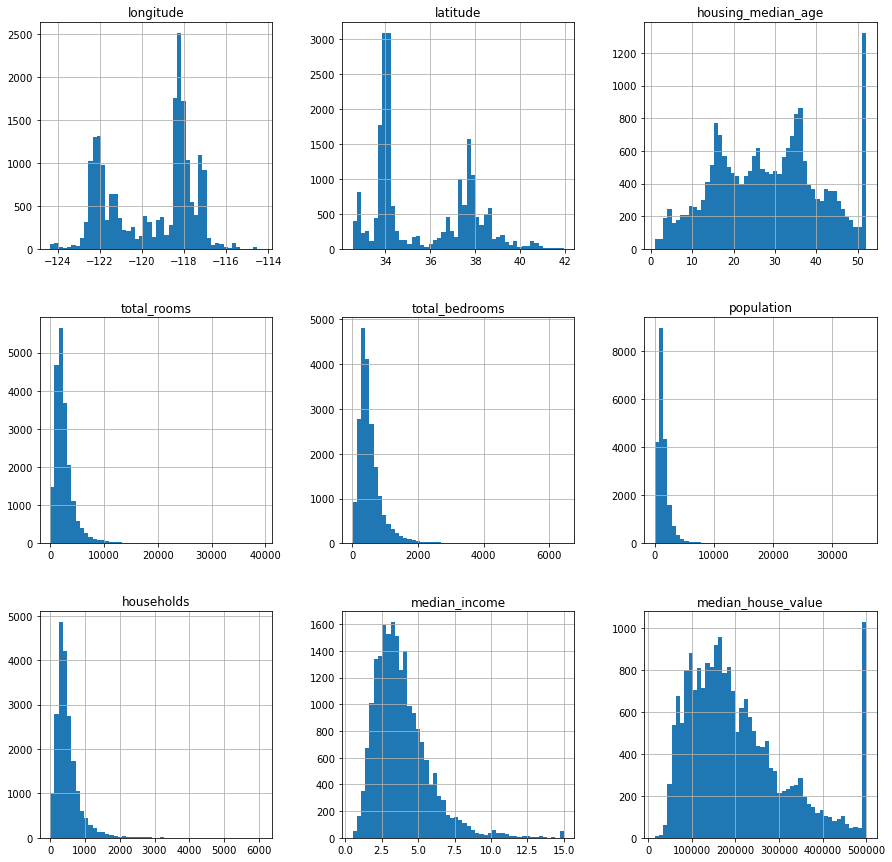

In [13]:
df.hist(bins=50,figsize=[15,15])
plt.show()

## Some insights from this first analysis:
- The features are tail-heavy, i.e., the instances lag to the right
- The features has scales that are too different from each other
- The median income are limited to the 0.5 and 15
- The housing_median_age feature in limited to 1 and 52
- The housing_median_value feature is limited to 500001.00

We now verify how correlated are the features with the target value (housing_median_value)
Note that corr() method only computes the linear correlation

<AxesSubplot:>

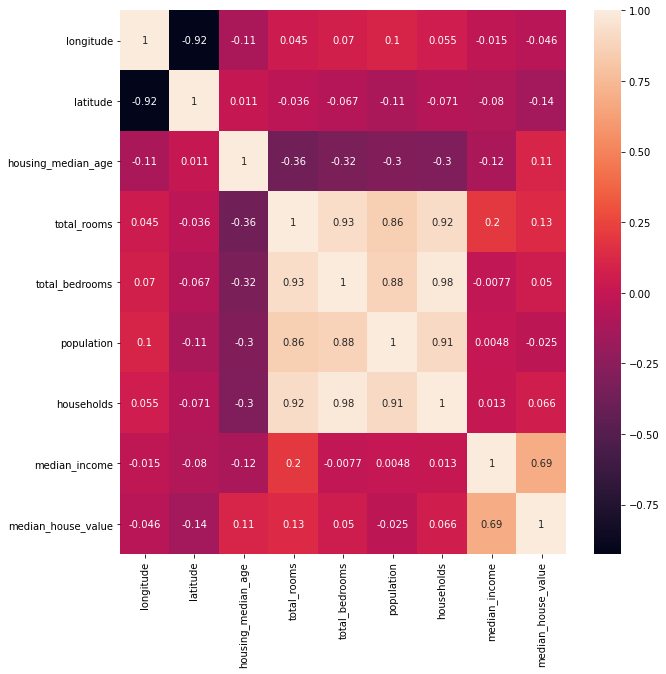

In [14]:
cor = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True)

## Data Splitting

We can see that the median_income has a great correlation with our target feature, which is the median_house_value. Therefore, we might use this information in the sampling process carried out through the data splitting.


In [15]:
# Once the correlation between these two features are very high, 
# we do not want to lose this information while splitting the data. 
# Therefore we categorize this linear feature, and we use in the sklearn.model_selectio.StratifiedShuffleSplit
# instead of using sklearn.model_selection.train_test_split
df['income_cat'] = pd.cut(  df['median_income'], bins = [0, 1.5, 3., 4.5, 6, np.inf], 
                            labels = [1, 2, 3, 4,5])
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


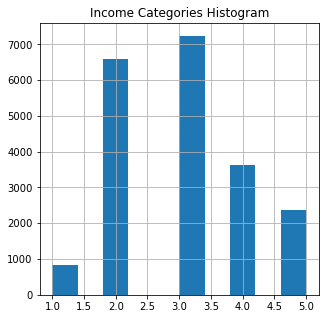

In [16]:
df['income_cat'].hist(figsize=(5,5))
plt.title('Income Categories Histogram')
plt.show()

In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state= 42)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set  = df.loc[test_index]

In [18]:
# We can see that the strat_train_set and stat_test_set keep the same proportions of the income_cat
pd.DataFrame({  'Train Set': strat_train_set['income_cat'].value_counts()/len(strat_train_set),
                'Test Set': strat_test_set['income_cat'].value_counts()/len(strat_test_set),
                'Original dataset': df['income_cat'].value_counts()/len(df)})

,Train Set,Test Set,Original dataset
3,0.350594,0.350533,0.350581
2,0.318859,0.318798,0.318847
4,0.176296,0.176357,0.176308
5,0.114402,0.114583,0.114438
1,0.039850,0.039729,0.039826


In [19]:
# Now we can drop the income_cat column on both train and test sets
for set_ in (strat_train_set, strat_test_set):
    if 'income_cat' in set_.columns:
        set_.drop('income_cat', axis = 1, inplace = True)

## Data Visualization

housing = strat_train_set.copy()

In [20]:
housing = strat_train_set.copy()

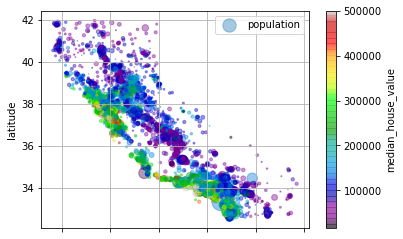

In [21]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
             s = housing['population']/100, label = 'population',
             c = 'median_house_value', cmap = plt.get_cmap('nipy_spectral'))
plt.grid(which = 'major')

In [22]:
housing['population'].describe()

count    16512.000000
mean      1419.790819
std       1115.686241
min          3.000000
25%        784.000000
50%       1164.000000
75%       1719.250000
max      35682.000000
Name: population, dtype: float64

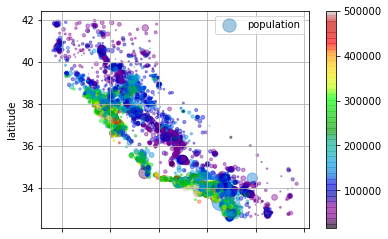

In [23]:
housing.plot(kind = "scatter", x = 'longitude', y = 'latitude', alpha = .4,
             s = housing['population']/100, label = 'population',
             c = housing['median_house_value'], cmap = plt.get_cmap('nipy_spectral'))
plt.grid()             

## Data Engineering
Here we create new features

<AxesSubplot:>

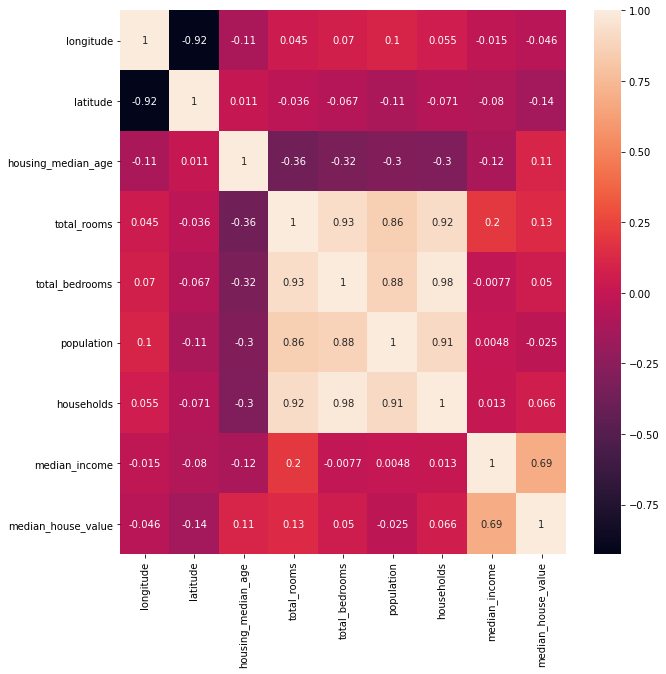

In [24]:
# Once again we take a look at the correlation map
cor = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot = True)

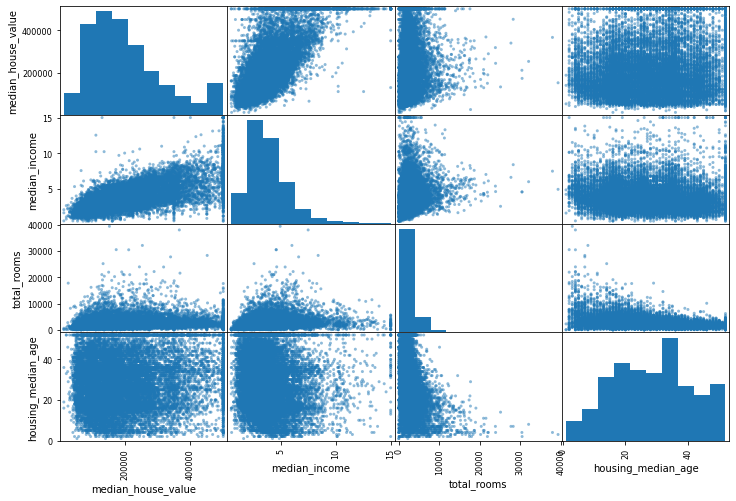

In [25]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing[attributes], figsize = (12,8), grid=True)
plt.show()

We can see a high correlation between median income (median_income) and the target feature (median_house_valeu)

Also, the price limit is observable, being limited to 500000. Also we see that there are some horizontal lines in the plot, in ~350000, ~450000

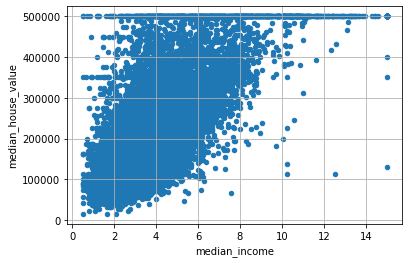

In [26]:
housing.plot(kind = 'scatter', y = 'median_house_value', x = 'median_income')
plt.grid()
plt.show()

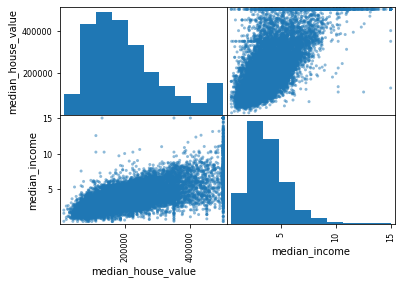

In [27]:
pd.plotting.scatter_matrix(housing[['median_house_value', 'median_income']], diagonal='hist')
plt.show()

We can see a high correlation between
- household and the total_bedrooms features
- total_rooms and total_bedrooms features
- population and households

Therefore, we create new features based on this information.
Also, the number of rooms in the region has no value without the number of households in that region. The relation between the size of the population and number of households is also valueble. Finally the relation between the number of bedrooms is way more valuable when we devide it by the total number of rooms.


In [28]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [29]:
cor = housing.corr()
cor['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Data cleaning

1) Break the dataset into the features X and the label y

In [30]:
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value']

2) Dealing with the NaN values imputing the mean

In [33]:
housing_NaN, housing_mean = data_cleaner_and_manipulator().treat_NaN(df = housing, type = 'fillna_mean')
housing_NaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## Manipulating text and categorical data


We first verify if there are any text feature

In [38]:
categorical_features = data_cleaner_and_manipulator().get_columns_of_specific_dtype(df = housing_NaN, dtype = 'object')
print('The list of categorical features is {0}'.format(categorical_features))

The list of categorical features is ['ocean_proximity']


In [41]:
housing_NaN['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

The majority of Machine Learning algorithms works better with numbers instead of texts.

In [83]:
data_cleaner_and_manipulator().

AttributeError: 'data_cleaner_and_manipulator' object has no attribute 'textEncoder'

In [76]:
data_cleaner_and_manipulator().textEncoder()

AttributeError: 'data_cleaner_and_manipulator' object has no attribute 'textEncoder'

In [68]:
housing_cat = data_cleaner_and_manipulator().textEncoder(df = housing_NaN)

AttributeError: 'data_cleaner_and_manipulator' object has no attribute 'textEncoder'